# 데이터
소스: https://github.com/ECSIM/pem-dataset1/tree/master/Standard%20Test%20of%20Nafion%20Membrane%20112
### 구조
- Anode: 
	- Carbon paper Ballard
	- Platinum-Carbon 20% 
	- Nafion solution (27% weight)
	- 80ml Isopropyl alcohol
	- 20ml double distilled water 
	- Loading of Platinum= 0.39 mg/cm2
- Cathode: 
	- Carbon paper Ballard
	- Platinum-Carbon 20%
	- Nafion solution (25% weight)
	- 80ml Isopropyl alcohol
	- 20ml double distilled water
	- Loading of Platinum= 0.39 mg/cm2

### 실험 환경
- Cell temperature= 75 C
- Anode temperature= 80 C
- Cathode temperature= 48-59-70-75 C

# 데이터 다운로드

In [8]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/GuGroup/ShortNNTutorial/main/NNExample/data.csv", "data.csv")

('data.csv', <http.client.HTTPMessage at 0x1b2b79336d0>)

# 데이터 불러오기
데이터 분석
<img src="https://github.com/GuGroup/ShortNNTutorial/blob/main/NNExample/img/data.png?raw=1" style="max-width: 800px;">

A열 - 전류 밀도 - 예측 하고 싶은 값

B열 - 셀 전압   - input 1

C열 - 수소 압력 - input 2

D열 - 상대 습도 - input 3

E열 - 막 압축   - input 4


# 파이썬상에서 데이터 불러오기

In [1]:
import csv
import torch

with open('/content/drive/MyDrive/data.csv') as f:
    reader = csv.reader(f)
    next(reader)
    data = []
    for row in reader:
        datum = []
        for column in row:
            datum.append(float(column))
        data.append(datum)

data = torch.Tensor(data)

y = data[:,:1]
x = data[:,1:]


# 데이터 섞기

In [2]:
randomized_idx = torch.randperm(data.shape[0])

train_ratio = 0.8
ntrain = int(data.shape[0]*train_ratio)

idx_train = randomized_idx[:ntrain]
idx_test = randomized_idx[ntrain:]

x_train = x[idx_train,:]
y_train = y[idx_train]

x_test  = x[idx_test,:]
y_test  = y[idx_test]



# 데이터 Normalization

In [3]:
x_train_mean = x_train.mean(0)
x_train_std = x_train.std(0)

x_train_normalized = (x_train -x_train_mean)/x_train_std
x_test_normalized = (x_test -x_train_mean)/x_train_std

y_train_mean  = y_train.mean()
y_train_std  = y_train.std()
y_train_normalized = (y_train - y_train_mean)/y_train_std
y_test_normalized = (y_test - y_train_mean)/y_train_std


# 모델 구축

In [4]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(4, 32),
                        torch.nn.Softplus(),
                        torch.nn.Linear(32, 32),
                        torch.nn.Softplus(),
                        torch.nn.Linear(32, 1))
        
    def forward(self, x):
        y = self.model(x)
        return y

model = NeuralNetwork()

# 모델 학습

In [5]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),0.001)
for i in range(10000):
    y_train_normalized_pred = model(x_train_normalized)
    loss = criterion(y_train_normalized_pred,y_train_normalized)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 1000 == 0:
        print(i,'%.5f'%loss)

0 1.45397
1000 0.02262
2000 0.01932
3000 0.00777
4000 0.00520
5000 0.00342
6000 0.00264
7000 0.00220
8000 0.00184
9000 0.00156


# 모델 테스트 

In [6]:
y_test_normalized_pred = model(x_test_normalized)
loss = criterion(y_test_normalized_pred,y_test_normalized)
print(loss)

y_test_pred = y_test_normalized_pred*y_train_std+y_train_mean
print(' Pred  Real')
for i in range(y_test_pred.shape[0]):
    print('%5.0f'%y_test_pred[i],'%5.0f'%y_test[i])


tensor(0.0025, grad_fn=<MseLossBackward0>)
 Pred  Real
   13    25
  563   557
  791   757
  190   188
 1516  1490
  124   141
  460   462
  114   114
  955   988
 1991  1960
   41    18
  828   832
  962   950
  346   341
 1153  1150
  288   237
   24     3
  105   109
  929   929
 1573  1590
  576   554
  739   756
 2084  2090
 1780  1770
  599   606
 1119  1090
  528   557
  642   636
  745   716
 1390  1400
   60    65
 1540  1520
 1112  1120
   59    61
  706   693
  778   774
  116   124
  299   297
  150   159
   -2     3
 1312  1340
   58    48
 1336  1340
  742   707
   50    54
   38    28
 1200  1180
  319   310
 1176  1220
  221   226
   13    11
 1003   953
  997  1060
 1715  1690
 1565  1580
 1045  1000
 1938  1990
 1720  1740
 1438  1350
  955   955
 1228  1230
  855   859
  844   872
 1071  1040
 1551  1450
  151   151
 1134  1140
  466   462
 1316  1240
 1169  1160
  100   115
  483   486
   61    37
 1236  1230
   53    36
  985   971
 1255  1250
  803   796
  979   9

# 예측 그림 그리기

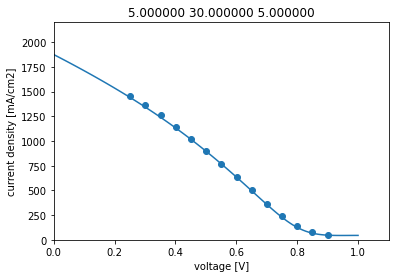

In [7]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import matplotlib.pyplot as plt

pressure = 5
relative_humidity =30
membrane_compression = 5

example_data = []
for d in data:
    if d[2] == pressure and d[3] == relative_humidity and d[4] ==membrane_compression:
        example_data.append(d)
example_data = torch.stack(example_data)

test_x_data = []
voltages = torch.linspace(0.0,1.0,100)
for v in voltages:
    test_x_data.append([v,pressure,relative_humidity,membrane_compression])
test_x_data = (torch.tensor(test_x_data) -x_train_mean)/x_train_std

test_y_data = model(test_x_data)
test_y_data = test_y_data.detach()
test_y_data = test_y_data*y_train_std+y_train_mean

plt.figure()
plt.scatter(example_data[:,1],example_data[:,0])
plt.ylabel('current density [mA/cm2]')
plt.xlabel('voltage [V]')
plt.ylim([0,2200])
plt.xlim([0,1.1])
plt.title('%f %f %f'%(pressure,relative_humidity,membrane_compression))
plt.plot(voltages,test_y_data)